In [1]:
### Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Librerias para modelos sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Librerias para redes neuronales
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

2023-11-22 18:22:01.363513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Importar datos - California housing
data = datasets.fetch_california_housing(as_frame=True).frame
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
## Preprocesamiento del dataset

# Eliminacion de variables irrelevantes
df = data.drop(columns=['Latitude', 'Longitude']).copy()

# Separación de X y y
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']

X.shape, y.shape

((20640, 6), (20640,))

In [5]:
# Escalado de los datos
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Separación del dataset train:val:test = 70%:21%:9%
X_train, X_rem, y_train, y_rem = train_test_split(X_sc, y, train_size=0.7)

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.3)

In [6]:
# Tamaño de los datasets
print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)
print(X_test.shape), print(y_test.shape)

(14447, 6)
(14447,)
(4335, 6)
(4335,)
(1858, 6)
(1858,)


(None, None)

In [10]:
### Construir ANN base

## Definición de hiperparámetros
dor = 0.3
sr = 0.1
l2 = keras.regularizers.l2(sr)

## ANN 1
ann1 = keras.models.Sequential(
    [
        keras.Input(shape=(6,)),
        keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2),
        keras.layers.Dropout(dor),
        keras.layers.Dense(64, activation = 'relu'),
        keras.layers.Dense(32, activation = 'relu'),
        keras.layers.Dense(1, activation = 'relu')
    ]
)

2023-11-22 18:49:37.876055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
ann1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________


In [12]:
m1 = keras.metrics.MeanAbsolutePercentageError(name='mape')

ann1.compile(
    optimizer = 'adam',
    loss = keras.losses.MeanSquaredError(),
    metrics = m1
)

history = ann1.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val))

Epoch 1/30
452/452 [==============================] - 2s 3ms/step - loss: 1.2221 - mape: 38.1905 - val_loss: 0.6365 - val_mape: 31.1349
Epoch 2/30
452/452 [==============================] - 2s 4ms/step - loss: 0.6347 - mape: 32.7059 - val_loss: 0.5749 - val_mape: 30.2794
Epoch 3/30
452/452 [==============================] - 1s 3ms/step - loss: 0.5748 - mape: 32.0313 - val_loss: 0.5211 - val_mape: 29.3810
Epoch 4/30
452/452 [==============================] - 2s 4ms/step - loss: 0.5502 - mape: 31.8260 - val_loss: 0.5222 - val_mape: 30.5291
Epoch 5/30
452/452 [==============================] - 1s 2ms/step - loss: 0.5365 - mape: 31.5707 - val_loss: 0.5151 - val_mape: 31.3761
Epoch 6/30
452/452 [==============================] - 2s 3ms/step - loss: 0.5340 - mape: 31.4668 - val_loss: 0.4871 - val_mape: 28.6863
Epoch 7/30
452/452 [==============================] - 1s 3ms/step - loss: 0.5208 - mape: 30.9699 - val_loss: 0.4869 - val_mape: 27.7501
Epoch 8/30
452/452 [============================

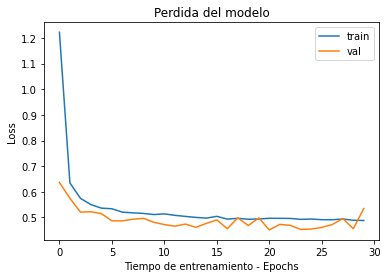

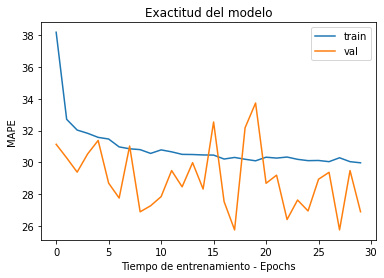

In [14]:
### Visualización de las curvas de error
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Tiempo de entrenamiento - Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

### Visualización de las curvas de error
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('Exactitud del modelo')
plt.xlabel('Tiempo de entrenamiento - Epochs')
plt.ylabel('MAPE')
plt.legend(['train', 'val'])
plt.show()

In [15]:
### Afinamiento de Hiperparámetros
hp = kt.HyperParameters()
lo = keras.losses.MeanSquaredError()
name_metric = "prueba"
m2 = keras.metrics.MeanAbsolutePercentageError(name = name_metric)

In [16]:
# Definición del Hyper Model
def tun_model(hp):
    dor = hp.Float('DOR', min_value = 0.1, max_value= 0.6, step=0.1)
    opt = hp.Choice('OPT', ['adam', 'sgd'])
    units_1 = hp.Int('UNITS_1', min_value = 64, max_value=512, step=32)

    ann = keras.models.Sequential(
        [
            keras.Input(shape=(6,),),
            keras.layers.Dense(units= units_1, activation = 'relu', kernel_regularizer=l2),
            keras.layers.Dropout(dor),
            keras.layers.Dense(64, activation = 'relu'),
            keras.layers.Dense(32, activation = 'relu'),
            keras.layers.Dense(1, activation = 'relu')
        ]
    )

    if opt == 'adam':
        opt = keras.optimizers.Adam(learning_rate=0.001)
    else:
        opt = keras.optimizers.SGD(learning_rate=0.001)

    ann.compile(optimizer= opt, loss=lo, metrics=m2)

    return ann

In [17]:
# Definicion del Tuner
search_model = kt.RandomSearch(
    hypermodel=tun_model,
    hyperparameters=hp,
    objective=kt.Objective(name_metric, direction="min"),
    max_trials=20,
    directory="results_tuner",
    project_name="california_housing"
)

In [18]:
# Ejecución Tuner
search_model.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
search_model.results_summary()

Trial 20 Complete [00h 00m 14s]
prueba: 32.48470687866211

Best prueba So Far: 29.93495750427246
Total elapsed time: 00h 04m 49s
Results summary
Results in results_tuner/california_housing
Showing 10 best trials
Objective(name="prueba", direction="min")

Trial 02 summary
Hyperparameters:
DOR: 0.1
OPT: adam
UNITS_1: 128
Score: 29.93495750427246

Trial 14 summary
Hyperparameters:
DOR: 0.1
OPT: adam
UNITS_1: 256
Score: 30.45846939086914

Trial 13 summary
Hyperparameters:
DOR: 0.1
OPT: adam
UNITS_1: 416
Score: 30.50872802734375

Trial 08 summary
Hyperparameters:
DOR: 0.30000000000000004
OPT: adam
UNITS_1: 192
Score: 30.63035774230957

Trial 16 summary
Hyperparameters:
DOR: 0.2
OPT: adam
UNITS_1: 288
Score: 30.649681091308594

Trial 12 summary
Hyperparameters:
DOR: 0.30000000000000004
OPT: adam
UNITS_1: 224
Score: 30.85044288635254

Trial 01 summary
Hyperparameters:
DOR: 0.30000000000000004
OPT: adam
UNITS_1: 320
Score: 30.964420318603516

Trial 10 summary
Hyperparameters:
DOR: 0.4
OPT: ada

In [19]:
best_model = search_model.get_best_models()[0]
hps = search_model.get_best_hyperparameters()[0]
hps.values

{'DOR': 0.1, 'OPT': 'adam', 'UNITS_1': 128}

In [20]:
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________


In [21]:
## Evaluación de la ANN
ann2 = best_model
pred_1 = ann2.predict(X_val)
pred_1.shape

136/136 [==============================] - 1s 2ms/step


(4335, 1)

In [22]:
y_pred_1 = np.array(pred_1)[:,0]
y_pred_1.shape

(4335,)

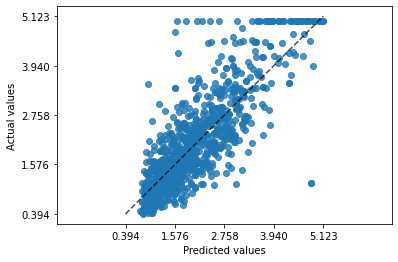

In [23]:
import sklearn.metrics as metrics

metrics.PredictionErrorDisplay.from_predictions(y_true= y_val, y_pred= y_pred_1, kind='actual_vs_predicted')

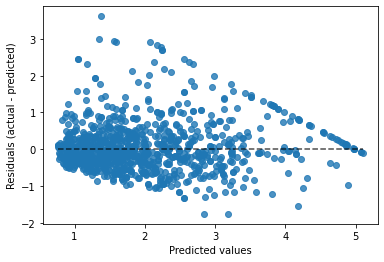

In [25]:
metrics.PredictionErrorDisplay.from_predictions(y_true= y_val, y_pred= y_pred_1, kind='residual_vs_predicted')

In [26]:
pred_2 = ann2.predict(X_test)
y_pred_2 = np.array(pred_2)[:,0]

59/59 [==============================] - 0s 3ms/step


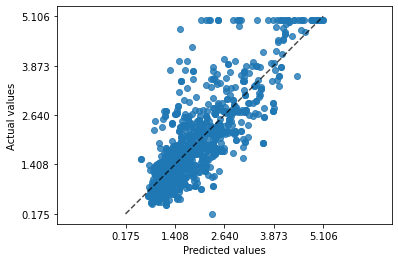

In [27]:
metrics.PredictionErrorDisplay.from_predictions(y_true= y_test, y_pred=y_pred_2, kind='actual_vs_predicted')

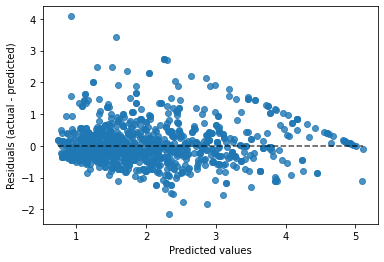

In [28]:
metrics.PredictionErrorDisplay.from_predictions(y_true= y_test, y_pred= y_pred_2, kind='residual_vs_predicted')